# Forest Type Mapping 

## Problem Statement
Given a set of features, classify whether the corresponding region is one of the following forest types
1. <b> s </b> : Sugi forest
2. <b> h </b> : Hinoki forest
3. <b> d </b> : Mixed deciduous forest
4. <b> o </b> : Other non-forest land


## TL;DR
* Explore the dataset
* Perform feature engineering
* Train a Decision Tree Classifier using cross-validation
* Train an SVM Classifier using cross-validation
* Compare the accuracy scores of the two models
* Comment on Accuracy vs. Interpretability

## Metadata
* Datasource : http://archive.ics.uci.edu/ml/datasets/Forest+type+mapping
* Data url : http://archive.ics.uci.edu/ml/machine-learning-databases/00333/ForestTypes.zip

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import pydot
import warnings
from collections import Counter
from urllib.request import urlopen

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)

In [2]:
train_df = pd.read_csv('training.csv')
test_df = pd.read_csv('testing.csv')

## Attribute Information:

* Class: 's' ('Sugi' forest), 'h' ('Hinoki' forest), 'd' ('Mixed deciduous' forest), 'o' ('Other' non-forest land)

* <b> b1 - b9 </b> : ASTER image bands containing spectral information in the green, red, and near infrared wavelengths for three dates (Sept. 26, 2010; March 19, 2011; May 08, 2011.

* <b> pred_minus_obs_S_b1 - pred_minus_obs_S_b9 </b> : Predicted spectral values (based on spatial interpolation) minus actual spectral values for the 's' class (b1-b9).

* <b> pred_minus_obs_H_b1 - pred_minus_obs_H_b9 </b> : Predicted spectral values (based on spatial interpolation) minus actual spectral values for the 'h' class (b1-b9).



In [3]:
train_df.head()

,class,b1,b2,b3,b4,b5,b6,b7,b8,b9,...,pred_minus_obs_H_b9,pred_minus_obs_S_b1,pred_minus_obs_S_b2,pred_minus_obs_S_b3,pred_minus_obs_S_b4,pred_minus_obs_S_b5,pred_minus_obs_S_b6,pred_minus_obs_S_b7,pred_minus_obs_S_b8,pred_minus_obs_S_b9
0,d,39,36,57,91,59,101,93,27,60,...,-2.36,-18.41,-1.88,-6.43,-21.03,-1.60,-6.18,-22.50,-5.20,-7.86
1,h,84,30,57,112,51,98,92,26,62,...,-2.26,-16.27,-1.95,-6.25,-18.79,-1.99,-6.18,-23.41,-8.87,-10.83
2,s,53,25,49,99,51,93,84,26,58,...,-1.46,-15.92,-1.79,-4.64,-17.73,-0.48,-4.69,-19.97,-4.10,-7.07
3,s,59,26,49,103,47,92,82,25,56,...,2.68,-13.77,-2.53,-6.34,-22.03,-2.34,-6.60,-27.10,-7.99,-10.81
4,d,57,49,66,103,64,106,114,28,59,...,-2.94,-21.74,-1.64,-4.62,-23.74,-0.85,-5.50,-22.83,-2.74,-5.84


In [4]:
# Extract Features
features = [ str1 + 'b' + str(i) for str1 in ('', 'pred_minus_obs_H_', 'pred_minus_obs_S_') for i in range(1, 10)]
X = train_df[features]
Y = train_df['class']

# Data Exploration

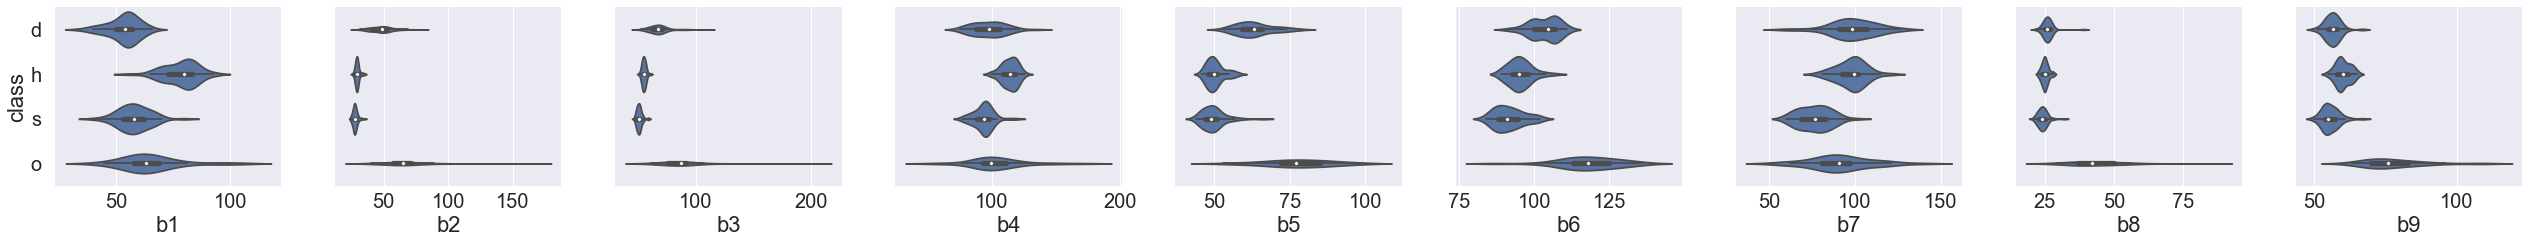

In [5]:
# Violin plots
g = sns.PairGrid(train_df,
                     x_vars=['b' + str(i) for i in range(1, 10)],
                     y_vars=["class"], size=4,)
g = g.map(sns.violinplot)

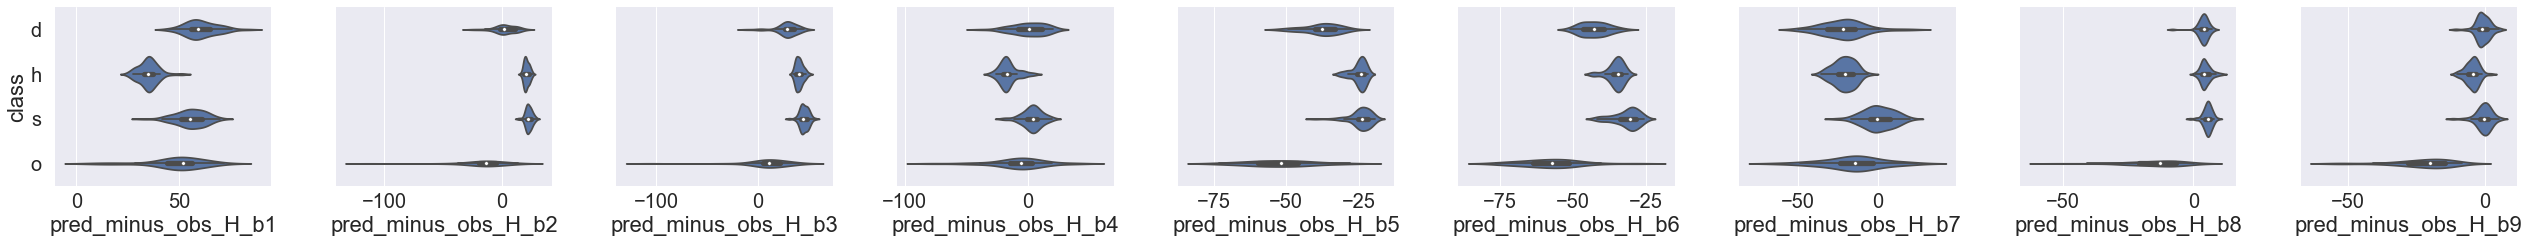

In [6]:
g = sns.PairGrid(train_df,
                     x_vars=['pred_minus_obs_H_b' + str(i) for i in range(1, 10)],
                     y_vars=["class"], size=4,)
g = g.map(sns.violinplot)

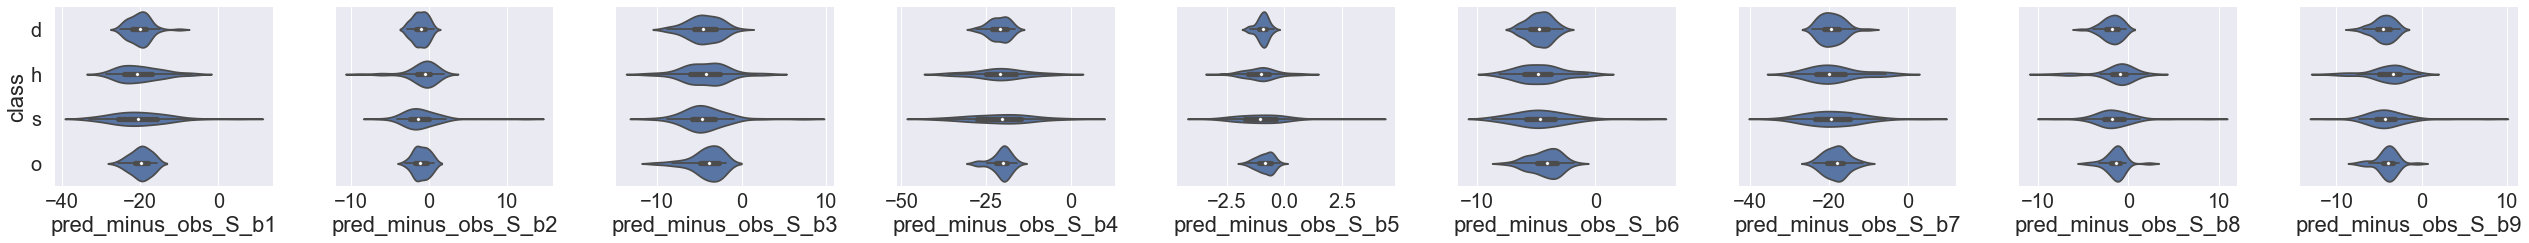

In [7]:
g = sns.PairGrid(train_df,
                     x_vars=['pred_minus_obs_S_b' + str(i) for i in range(1, 10)],
                     y_vars=["class"], size=4,)
g = g.map(sns.violinplot)

## Observation
* The distribution of the features across different classes does not show any apparent patterns, as seen from the above plots
* May be a correlation plot will help

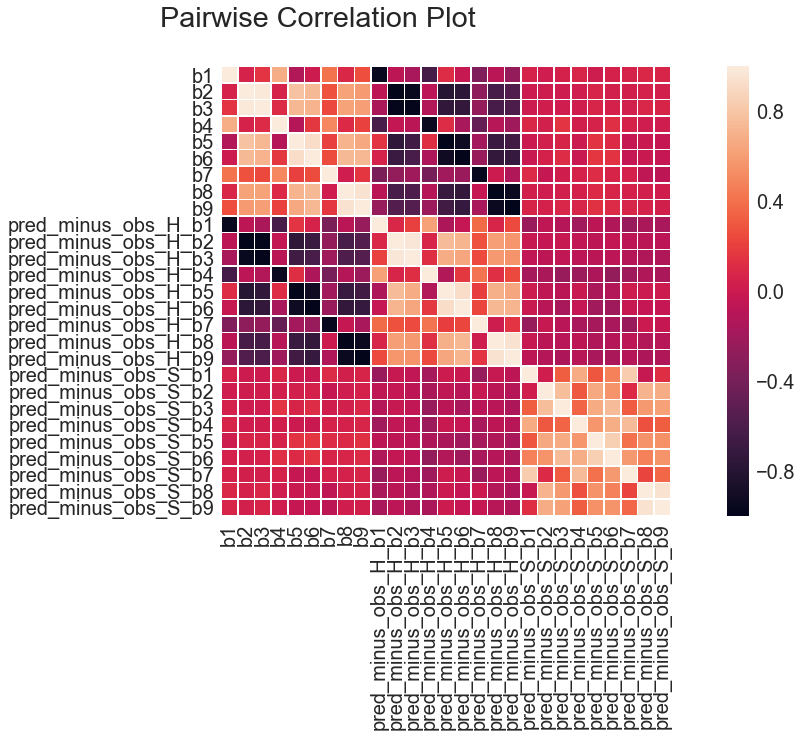

In [8]:
# show Correlation plot
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, linewidths=0.5, square=True, yticklabels=True)
plt.suptitle("Pairwise Correlation Plot")
plt.show()

## Observation
* There are a lot of pairwise highly correlated features
* Removing the redundant features might help improve the performance

## Data Pre-processing

In [9]:
def pre_process_data(input_df):
    """ Drop one of the features among those that are pair-wise highly correlated
        ie. drop all obs_H features and obs_S_b9 feature
    """
    new_features = [ feature for feature in features if 'obs_H' not in feature and 'obs_S_b9' not in feature]
    return input_df[new_features]

## Correlation Plot after Data Processing

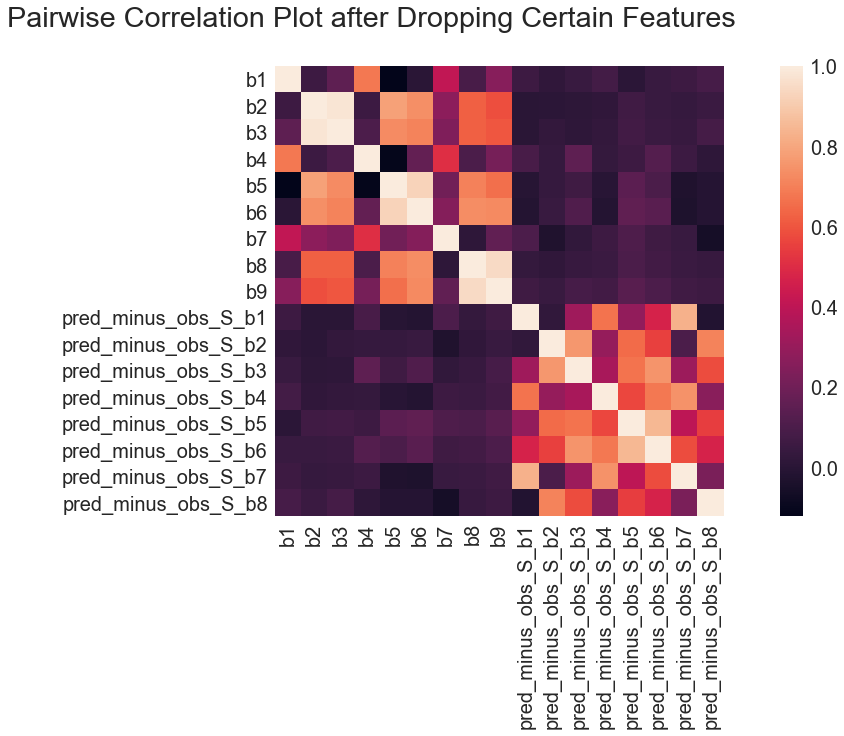

In [10]:
correlation_matrix = pre_process_data(X).corr()
sns.heatmap(correlation_matrix, square=True, yticklabels=True)
plt.suptitle("Pairwise Correlation Plot after Dropping Certain Features")
plt.show()

## Decision Tree Classifier (DTC)

In [11]:
def train_tree_classifier(X, Y):
    """ Given X and Y train a decision tree classifier using Grid search and Cross validation
        Return the best model
        Create a graph(.png image) of the created tree and write to a file
    """
    n_features = len(X.columns)
    params = {'max_depth' : [i for i in range(1, 10) ] + [None],
              'min_samples_split' : range(2, 15), 
              'max_features' : [i for i in range(2, n_features)] + [None]}

    model = GridSearchCV(DecisionTreeClassifier(random_state=1000), param_grid=params, cv=5,  
                             scoring='accuracy', 
                             refit=True,
                             verbose=1, n_jobs=5)
    model.fit(X, Y)

    best_classifier = model.best_estimator_

    # Export graph tree
    with open('treeviz.dot', 'w') as fd:
        export_graphviz(best_classifier, out_file = fd, feature_names = X.columns)

    # Create PNG image of the graph
    graph = pydot.graph_from_dot_file('treeviz.dot')[0]
    graph.write_png('tree.png')

    print("Validation Accuracy Score : ", model.best_score_)
    return best_classifier

## Train the Decision Tree Classifier

In [12]:
clf = train_tree_classifier(pre_process_data(X), Y)

Fitting 5 folds for each of 2080 candidates, totalling 10400 fits


[Parallel(n_jobs=5)]: Done 1310 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 9710 tasks      | elapsed:    8.6s


Validation Accuracy Score :  0.944444444444


[Parallel(n_jobs=5)]: Done 10400 out of 10400 | elapsed:    9.1s finished


In [13]:
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1000, splitter='best')

## Comment:
* The visualization of the trained decision tree can be found in <b> tree.png </b>

## Compute Test-Set Accuracy

In [14]:
X_test = test_df[features]
Y_test = test_df['class']

predictions = clf.predict(pre_process_data(X_test))
tree_test_accuracy = accuracy_score(predictions, Y_test)
tree_test_accuracy

0.80307692307692302

## SVM Classifier

In [15]:
def train_svm_classifier(X, Y):
    """ 
    """
    n_features = len(X.columns)
    params = {'C' : [i for i in np.arange(.01, 1, 0.1)],
              'kernel' : ['poly', 'rbf', 'linear'],
              'gamma' : [0.01 * i / n_features for i in range(1,15)],
              'degree' : [i for i in range(3)]}

    model = GridSearchCV(SVC(random_state=1000), param_grid=params, cv=5,  
                             scoring='accuracy', 
                             refit=True,
                             verbose=1, n_jobs=5)
    model.fit(X, Y)

    best_classifier = model.best_estimator_


    print("Validation Accuracy Score : ", model.best_score_)
    return best_classifier

## Train SVM Classifer

In [16]:
svm_classifier = train_svm_classifier(pre_process_data(X), Y)

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


[Parallel(n_jobs=5)]: Done 1110 tasks      | elapsed:    1.7s


Validation Accuracy Score :  0.944444444444


[Parallel(n_jobs=5)]: Done 6300 out of 6300 | elapsed:    9.6s finished


In [17]:
svm_classifier

SVC(C=0.91000000000000003, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma=0.007647058823529412,
  kernel='poly', max_iter=-1, probability=False, random_state=1000,
  shrinking=True, tol=0.001, verbose=False)

## Compute Test Accuracy

In [18]:
predictions = svm_classifier.predict(pre_process_data(X_test))
svm_test_accuracy = accuracy_score(predictions, Y_test)
svm_test_accuracy

0.87384615384615383

In [19]:
model = ['Decision Tree', "Support Vector Machine"]
test_set_accuracy = list(map(lambda x : str(round(x * 100, 2)) + "%", [tree_test_accuracy, svm_test_accuracy]))
results = pd.DataFrame({'Model' : model, 'Test Set Accuracy' : test_set_accuracy})

## Summary of Results

In [20]:
results

,Model,Test Set Accuracy
0,Decision Tree,80.31%
1,Support Vector Machine,87.38%


# Conclusion

* Even though both DTC and SVM perform equaly well on the validation set(generated from the train set), SVM performs better on the test(hold out) data set
* However, the DTC is more interpretable than SVM as it is easy to visualize the classification decision process in a decision tree
* If we only care about prediction accuracy, the SVM is a good classfier in this case. 
* On the other hand, if we care about interpretability with a decent accuracy score, DTC is going to be very useful